# New Grid MCMC with Stellar Atmospheres

Started 29 October 2019. This notebook is meant to (finally) incorporate stellar atmospheres into the MCMC fit. Resampling is done in the actual MCMC to not have too many points. Let's see how this works. Interpolating the grid of stellar atmospheres onto the same grid as the points for fast computation.

### Imports

In [27]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from scipy import integrate
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from fu_ori_functions_oct29 import *
from fu_ori_classes_oct29 import *
import matplotlib.gridspec as gridspec
from PyAstronomy import pyasl
import scipy.signal as signal

import emcee
import corner
import time
%matplotlib inline 

In [2]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16

In [3]:
ATM_TABLE = dict()
ATMOS_FACTOR = 100

In [4]:
def getDataArrayMOD(data_file):
    txt = open(data_file)
    fulltxt = txt.readlines()
    # Cleaning lines
    newtxt = []
    for i in range(0,len(fulltxt), 2):
        line = fulltxt[i][:-1]
        line = line.split()
        if line[0] == '#':
            line = [line[1], line[2]]
        newtxt.append(line)
    # Casting as floats
    newtxt = np.array(newtxt).astype(np.float64)
    return newtxt

In [5]:
def direcToArray(directory):
    for temp in range(2000, 10000+ATMOS_FACTOR, ATMOS_FACTOR):
        for grav in [1.5, 4.0]:
            try:
                atmos_file = directory + 'pr.lte' + str(int(temp/ATMOS_FACTOR)) \
                        + '-' + str(grav) + '-0.0.spec'
                txt = open(atmos_file)
                fulltxt = txt.readlines()
                # Cleaning lines
                newtxt = []
                for i in range(len(fulltxt)):
                    line = fulltxt[i][:-1]
                    line = line.split()
                    newtxt.append(line)
        
                # Casting as floats
                newtxt = np.array(newtxt).astype(np.float64)
                
                # Choosing which model to use
                wav, lum = newtxt[:,0], newtxt[:,1]
                ATM_TABLE[(temp, grav)] = np.array([wav, lum])
            except:
                print('No atmosphere found for temp = ' + str(temp) + \
                      ' grav = ' + str(grav))

In [6]:
direcToArray('C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/')

No atmosphere found for temp = 7100 grav = 1.5
No atmosphere found for temp = 7100 grav = 4.0
No atmosphere found for temp = 7300 grav = 1.5
No atmosphere found for temp = 7300 grav = 4.0
No atmosphere found for temp = 7500 grav = 1.5
No atmosphere found for temp = 7500 grav = 4.0
No atmosphere found for temp = 7700 grav = 1.5
No atmosphere found for temp = 7700 grav = 4.0
No atmosphere found for temp = 7900 grav = 1.5
No atmosphere found for temp = 7900 grav = 4.0
No atmosphere found for temp = 8100 grav = 1.5
No atmosphere found for temp = 8100 grav = 4.0
No atmosphere found for temp = 8300 grav = 1.5
No atmosphere found for temp = 8300 grav = 4.0
No atmosphere found for temp = 8500 grav = 1.5
No atmosphere found for temp = 8500 grav = 4.0
No atmosphere found for temp = 8700 grav = 1.5
No atmosphere found for temp = 8700 grav = 4.0
No atmosphere found for temp = 8900 grav = 1.5
No atmosphere found for temp = 8900 grav = 4.0
No atmosphere found for temp = 9100 grav = 1.5
No atmosphere

### Interpolating grid of stellar atmospheres on same grid as data:

First, reading in data...

In [323]:
txt_in = getDataArrayMOD('hbc_out_new_calib.csv')
WAV_DAT = txt_in[:,0]
FLUX_DAT = txt_in[:,1]
FLUX_DAT_ERR = -0.01*FLUX_DAT

In [324]:
import spectres

In [325]:
def getInterpTable(st_atm_table, waves_data):
    out_table = dict()
    for key in ATM_TABLE:
        wav, lum = ATM_TABLE[key]
#         interp_func = interpolate.interp1d(wav, lum, kind = 'linear')
#         out_table[key] = waves_data, interp_func(waves_data)
        out_table[key] =  waves_data, spectres.spectres(waves_data, wav, lum)
    return out_table

In [326]:
WAVES_DATA_LOGGED = WAV_DAT

In [327]:
len(WAVES_DATA_LOGGED)

435

In [328]:
WAVES_DATA = 1e4*(10**WAVES_DATA_LOGGED)

In [329]:
ATM_TABLE_INTERP = getInterpTable(ATM_TABLE, WAVES_DATA)

In [330]:
ATM_TABLE_INTERP.keys()

dict_keys([(2000, 1.5), (2000, 4.0), (2100, 1.5), (2100, 4.0), (2200, 1.5), (2200, 4.0), (2300, 1.5), (2300, 4.0), (2400, 1.5), (2400, 4.0), (2500, 1.5), (2500, 4.0), (2600, 1.5), (2600, 4.0), (2700, 1.5), (2700, 4.0), (2800, 1.5), (2800, 4.0), (2900, 1.5), (2900, 4.0), (3000, 1.5), (3000, 4.0), (3100, 1.5), (3100, 4.0), (3200, 1.5), (3200, 4.0), (3300, 1.5), (3300, 4.0), (3400, 1.5), (3400, 4.0), (3500, 1.5), (3500, 4.0), (3600, 1.5), (3600, 4.0), (3700, 1.5), (3700, 4.0), (3800, 1.5), (3800, 4.0), (3900, 1.5), (3900, 4.0), (4000, 1.5), (4000, 4.0), (4100, 1.5), (4100, 4.0), (4200, 1.5), (4200, 4.0), (4300, 1.5), (4300, 4.0), (4400, 1.5), (4400, 4.0), (4500, 1.5), (4500, 4.0), (4600, 1.5), (4600, 4.0), (4700, 1.5), (4700, 4.0), (4800, 1.5), (4800, 4.0), (4900, 1.5), (4900, 4.0), (5000, 1.5), (5000, 4.0), (5100, 1.5), (5100, 4.0), (5200, 1.5), (5200, 4.0), (5300, 1.5), (5300, 4.0), (5400, 1.5), (5400, 4.0), (5500, 1.5), (5500, 4.0), (5600, 1.5), (5600, 4.0), (5700, 1.5), (5700, 4.0), (

In [331]:
class FUOriEnvironment:
    
    # Initializer / Instance Attributes
    def __init__(self, wave_lower_SED, wave_upper_SED):
        
        self.wave_lower_SED = wave_lower_SED
        self.wave_upper_SED = wave_upper_SED
        
        # Storing classes
        self.fuori = 0
        
    # instance methods
    
    # Creating FU Ori object as accretion disk
    def createFUOri(self, r_star, r_outer, m_star, m_dot, inc, dist, grav, direc, a_v, atm_table):
        fuori = FUOri(r_star, r_star, r_outer, m_star, m_dot, np.radians(inc), a_v, atm_table)
        fuori.setAnnuliValues(10000, 2000, 200, 2*R_STAR)
        fuori.createAnnuliFromDirec(grav, direc, 'stellar atmospheres')
        fuori.createModelSpectrum('stellar atmospheres', False)
        self.fuori = fuori

### Making an instance of the class

In [332]:
PARAMS = [0.61433545, 1.52233487, 0.95156863]

In [333]:
M_STAR = PARAMS[0]*M_SUN
R_STAR= PARAMS[1]*R_SUN
R_OUTER = 100 * R_STAR
M_DOT = (10**PARAMS[2]) * 1e-6 * M_SUN / 3.154e7

A_V = 3.7
INC = 60
DIST = 795*3.08567758128e18
DIREC = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/'

In [334]:
%time gaia17bpi_env = FUOriEnvironment(3.0e3, 28.5e3)
%time gaia17bpi_env.createFUOri(r_star = R_STAR, r_outer = R_OUTER, m_star = M_STAR,\
                          m_dot = M_DOT, inc = INC, a_v = A_V,dist = DIST, grav = 1.5, \
                                direc = DIREC, atm_table=ATM_TABLE_INTERP)

Wall time: 0 ns
Wall time: 20.7 ms


### Quick minimization routine

In [335]:
def getLstSqrs(theta):
    m_star, r_star, m_dot= theta
    r_star = r_star*R_SUN
    m_dot = 10**m_dot
    m_star = m_star*M_SUN
    inc = 60
    m_dot = m_dot* 1e-6 * M_SUN / 3.154e7
    a_v = 3.7

    gaia17bpi_env = FUOriEnvironment(3.0e3, 28.5e3)
    try:
        gaia17bpi_env.createFUOri(r_star = r_star, r_outer = R_OUTER, m_star = m_star,\
                          m_dot = m_dot, inc = inc, a_v = a_v, dist = DIST, grav = 1.5, \
                              direc = DIREC, atm_table=ATM_TABLE_INTERP)
    except:
        gaia17bpi_env.createFUOri(r_star = r_star*2, r_outer = R_OUTER, m_star = m_star,\
                          m_dot = m_dot, inc = inc, a_v = a_v, dist = DIST, grav = 1.5, \
                              direc = DIREC, atm_table=ATM_TABLE_INTERP)

    x = WAV_DAT
    # Converting units to properly compare model to data
    x_new = (10**x)*1e4
    modSpec = np.zeros(len(x_new))
    modSpec = gaia17bpi_env.fuori.mod_spec_lums
    modSpec = pyasl.unred(x_new, modSpec, -a_v/3.1)
    flux = np.cos(np.radians(inc))*modSpec/(2*np.pi*DIST**2)

    model = np.log10(x_new*flux*1e-8)
    data = FLUX_DAT

    return np.sum((model - data)**2)

In [336]:
from scipy import optimize
x0 = [0.5, 2.2, 1.2]
optimize.minimize(getLstSqrs, x0, method='Nelder-Mead', tol=1e-6)

 final_simplex: (array([[0.59102573, 1.4219773 , 0.93615288],
       [0.59102653, 1.4219773 , 0.93615229],
       [0.59102603, 1.42197731, 0.93615266],
       [0.5910249 , 1.42197729, 0.93615348]]), array([1.19924013, 1.19924013, 1.19924013, 1.19924013]))
           fun: 1.1992401264100976
       message: 'Optimization terminated successfully.'
          nfev: 183
           nit: 97
        status: 0
       success: True
             x: array([0.59102573, 1.4219773 , 0.93615288])

In [337]:
wav, lum = gaia17bpi_env.fuori.mod_spec_waves, gaia17bpi_env.fuori.mod_spec_lums
lum = pyasl.unred(wav, lum, -A_V/3.1)

In [338]:
gaia17bpi_env.fuori.annuli[0].temp, gaia17bpi_env.fuori.getTotalLum()/L_SUN

(8200.0, 55.978177880073716)

### Plotting data with model

In [339]:
model_wav = np.log10(wav*1e-4)
model_wav_flux =  np.log10(lum*wav*1e-8*np.cos(np.radians(INC))/(2*np.pi*DIST**2))

In [340]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [341]:
b, a = signal.butter(1, 0.25, 'low', analog=False)
filtered_signal = signal.filtfilt(b, a,  model_wav_flux)

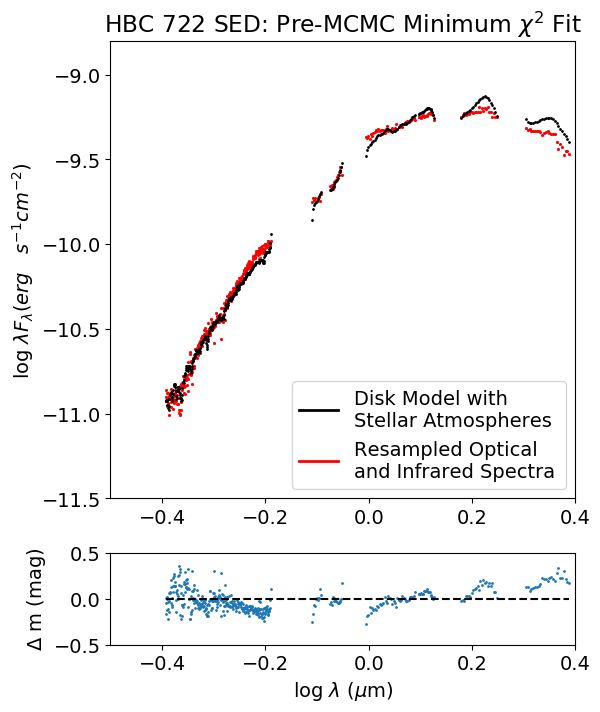

In [344]:
fig=plt.figure(figsize=(6, 8), dpi= 100)
gs = gridspec.GridSpec(2, 1,height_ratios=[5, 1])
plt.rcParams.update({'font.size': 14})

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


# plt.errorbar(WAV_DAT, FLUX_DAT, yerr=FLUX_DAT_ERR, marker='o', \
#              linestyle='', color='r', alpha=1, label='Palomar + IRTF \nResampled Spectra')

ax.plot(WAV_DAT, FLUX_DAT, 'ro', markersize=1, alpha=1, label='Resampled Spectra')
ax.plot(WAV_DAT, FLUX_DAT, 'ro', markersize=1, alpha=1, label='Resampled Spectra')
# ax.plot(model_wav,model_wav_flux, \
#          'ko', markersize = 1,  label='Stellar Atmospheres \n Acc. Disk (unsmoothed)')

ax.plot(model_wav, filtered_signal,'ko' , markersize = 1,  label='Stellar Atmospheres \n Acc. Disk (smoothed)')

# ax2.plot(model_wav, 100*(model_wav_flux - FLUX_DAT)/model_wav_flux, 'o', markersize=1)
# ax2.plot(model_wav, np.zeros(len(model_wav_flux)), 'k--')


# ax2.set_xlabel(r'log $\lambda$ ($\mu$m)')
# ax2.set_ylabel('Percent \nDifference')
# ax2.set_xlim(-0.5, 0.4)
# ax2.set_ylim(-2,2)

ax2.plot(model_wav, (1/0.4)*np.log10((10**filtered_signal)/(10**FLUX_DAT)), 'o', markersize=1)
ax2.plot(model_wav, np.zeros(len(model_wav_flux)), 'k--')


ax2.set_xlabel(r'log $\lambda$ ($\mu$m)')
ax2.set_ylabel(r'$\Delta$ m (mag)')
ax2.set_xlim(-0.5, 0.4)
ax2.set_ylim(-0.5,0.5)

ax.set_ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')


ax.set_title(r'HBC 722 SED: Pre-MCMC Minimum $\chi^2$ Fit')
ax.set_ylim(-11.5, -8.8)
ax.set_xlim(-0.5, 0.4)

# ax2.set_yticks([-5, -2.5, 0, 2.5, 5])
legend_elements = [Line2D([0], [0], color='k', lw=2, label='Disk Model with \nStellar Atmospheres '),
                   Line2D([0], [0], color='r', lw=2, label='Resampled Optical \nand Infrared Spectra')]
ax.legend(handles=legend_elements)
# plt.savefig("sed_hbc722_initial.png", dpi=200, bbox_inches='tight')
plt.show()

## Finding $\chi^2$ value

In [26]:
getLstSqrs(PARAMS)

ValueError: too many values to unpack (expected 3)

## MCMC Routine

In [ ]:
def lnlike(theta, x, y, yerr):
    m_star, r_star, a_v, m_dot, inc = theta
    r_star = r_star*R_SUN
    m_dot = 10**m_dot
#     m_star = 10**m_star
    m_star = m_star*M_SUN
    inc = np.degrees(np.arccos(inc))

    m_dot = m_dot* 1e-6 * M_SUN / 3.154e7
    try:
    
        gaia17bpi_env = FUOriEnvironment(3.0e3, 28.5e3)
        gaia17bpi_env.createFUOri(r_star = r_star, r_outer = R_OUTER, m_star = m_star,\
                              m_dot = m_dot, inc = inc, a_v = a_v, dist = DIST, grav = 4.0, \
                                  direc = DIREC, atm_table=ATM_TABLE_INTERP)
    
    # Accounts for any random case where the model may not be generated properly given a certain combination
    # of parameters. This has only happened once, but it's presumably when the maximum temperature is too low.
    except:
        return 0
        
    
    # Converting units to properly compare model to data
    x_new = (10**x)*1e4
    modSpec = np.zeros(len(x_new))
    modSpec = gaia17bpi_env.fuori.mod_spec_lums
#     for i in range(len(x)):
#         modSpec[i] = gaia17bpi_env.getModSpecPoint(x[i], True)
    modSpec = pyasl.unred(x_new, modSpec, -a_v/3.1)
    flux = np.cos(np.radians(inc))*modSpec/(2*np.pi*DIST**2)

    model = np.log10(x_new*flux*1e-8)
    inv_sig = 1/yerr
    return np.sum(np.log((1/np.sqrt(2*np.pi))*inv_sig) - 0.5*((y - model)*inv_sig)**2)

In [27]:
M_STAR_LOW = 0.1
M_STAR_HIGH = 1.0

R_STAR_LOW = 0.2
R_STAR_HIGH = 8.0

M_DOT_LOW = -1.5
M_DOT_HIGH = 2.5

A_V_LOW = 1.
A_V_HIGH = 6.

INC_LOW = np.cos(np.radians(89))
INC_HIGH = np.cos(np.radians(1))

In [28]:
INC_LOW, INC_HIGH

(0.0174524064372836, 0.9998476951563913)

In [29]:
def lnprior(theta):
    m_star, r_star, a_v, m_dot, inc = theta
    if M_DOT_LOW  < m_dot < M_DOT_HIGH \
    and M_STAR_LOW < m_star < M_STAR_HIGH\
    and A_V_LOW < a_v < A_V_HIGH\
    and R_STAR_LOW < r_star < R_STAR_HIGH\
    and INC_LOW < inc < INC_HIGH:
        return 0.0
    return -np.inf

In [30]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp + lnlike(theta, x, y, yerr))

In [31]:
ndim, nwalkers = 5, 18
m_star_start = 0.67670139
r_star_start = 1.50484512
a_v_start = 2.61994882
m_dot_start = 0.63532007
inc_start = np.cos(np.radians(45))
start = np.array((m_star_start, r_star_start, a_v_start, m_dot_start, inc_start))
pos = [start + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

In [33]:
x = WAV_DAT
y_meas = FLUX_DAT
y_err = FLUX_DAT_ERR

In [34]:
len(WAV_DAT), len(gaia17bpi_env.fuori.mod_spec_lums)

(435, 435)

In [35]:
lnprob((m_star_start, r_star_start, a_v_start, m_dot_start, inc_start), x,y_meas,y_err)

506.56588385742623

In [119]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y_meas, y_err))
%time sampler.run_mcmc(pos, 6000, progress=True)

C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\emcee\ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [10:33<00:00,  9.09it/s]


Wall time: 10min 33s


State([[0.42362928 1.54245069 2.47195551 0.82093737 0.08666538]
 [0.71061902 1.62610945 2.27462214 0.56417556 0.5462474 ]
 [0.32694046 1.66931771 2.36951436 0.94937067 0.44153664]
 [0.41676195 1.67640185 2.33489017 0.84111623 0.10548551]
 [0.78626862 1.60647489 2.30996294 0.53129585 0.55114464]
 [0.51181712 1.49382706 2.51820645 0.71766049 0.5703921 ]
 [0.38716785 1.7269667  2.32214334 0.88965435 0.66128391]
 [0.65450386 1.63492185 2.32643306 0.62495833 0.74947974]
 [0.80774633 1.59480229 2.36954411 0.52882281 0.75355761]
 [0.94016417 1.66583538 2.35378284 0.48818118 0.11814231]
 [0.85019178 1.62333163 2.37469003 0.52307111 0.83794839]
 [0.69647188 1.75968877 2.13739273 0.60345416 0.58835508]
 [0.64867399 1.67694328 2.36968933 0.65978648 0.5377751 ]
 [0.77545118 1.5389328  2.41715628 0.54113834 0.76236375]
 [0.50309235 1.57383914 2.42386985 0.74581009 0.20920008]
 [0.60201168 1.58446786 2.44058563 0.66717226 0.79767279]
 [0.66366188 1.6719247  2.28283881 0.62253817 0.50470488]
 [0.5115

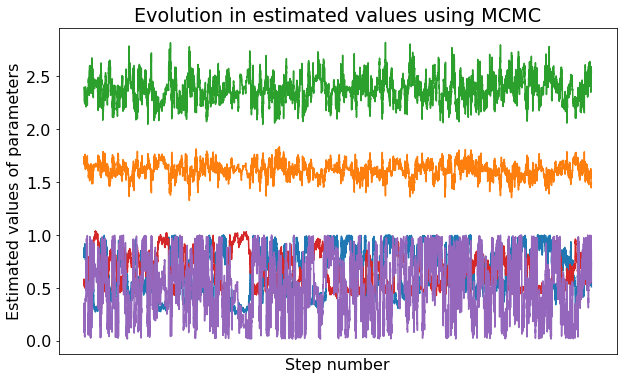

In [120]:
samples = sampler.chain[:, 3000:, :].reshape((-1, ndim))
fig = plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 16})

plt.plot(samples)
plt.xlabel('Step number')
plt.ylabel('Estimated values of parameters')
plt.title('Evolution in estimated values using MCMC')
plt.xticks([])
plt.show()

Quantiles:
[(0.16, 0.43419393260586947), (0.5, 0.6692354669944414), (0.84, 0.9080341799186258)]
Quantiles:
[(0.16, 1.551367573120809), (0.5, 1.618568706980803), (0.84, 1.6780224663598746)]
Quantiles:
[(0.16, 2.256111127115897), (0.5, 2.371256371170521), (0.84, 2.4791045258744355)]
Quantiles:
[(0.16, 0.48949887586766155), (0.5, 0.6210669669435286), (0.84, 0.8084390993915219)]
Quantiles:
[(0.16, 0.1865523051035261), (0.5, 0.523721465930183), (0.84, 0.84402146894759)]


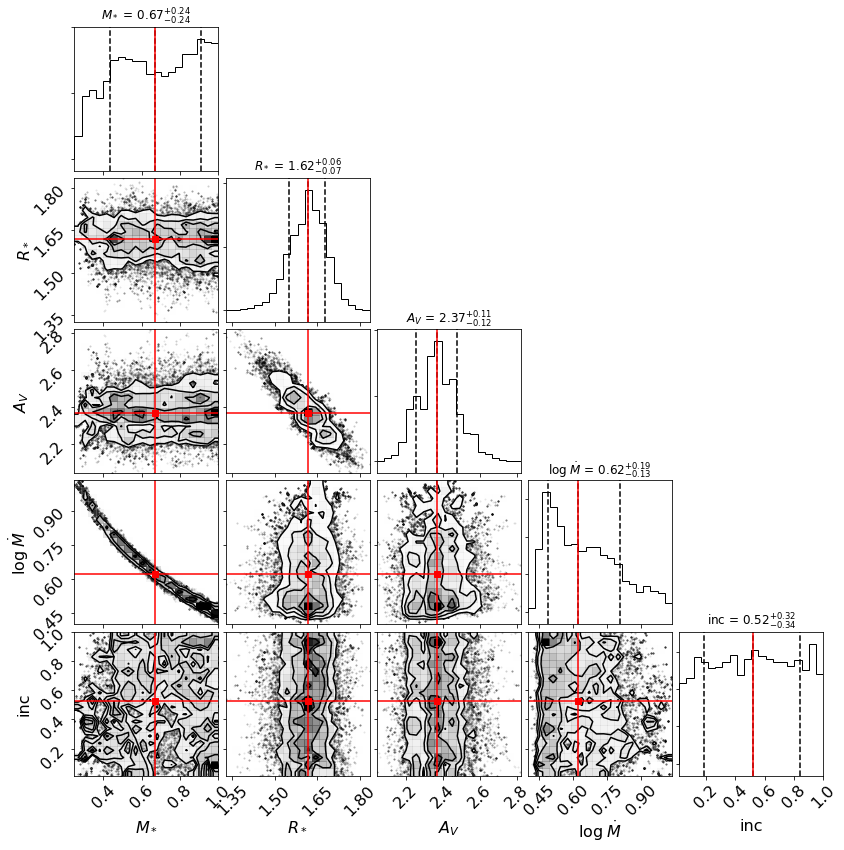

In [122]:
median_calcuated = np.median(samples, axis=0)

fig = corner.corner(samples, labels=[r'$ M_*$', r'$R_*$', r'$A_V$',r'$\log\;\dot{M}$', 'inc'], verbose=True,
                       quantiles=(0.16, 0.5,0.84), plot_contours=True, scale_hist=True,
                       show_titles=True, title_kwargs={"fontsize": 12})

axes = np.array(fig.axes).reshape((ndim, ndim))

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(median_calcuated[i], color="r")
    
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(median_calcuated[xi], color="r")
        ax.axhline(median_calcuated[yi], color="r")
        ax.plot(median_calcuated[xi], median_calcuated[yi], "sr")

fig.show()
# fig.savefig("hbc722_5param_jan14.png", dpi=140)